# **Spatial-Spectral Summarizer Fusion Network (S³F-Net) Baseline Implementation**

This notebook contains the full implementation of **Spatial CNN-based Baseline** on the BRISC 2025 (Brain MRI Segmentation and Classification) dataset, for comparisons with **S³F-Net**. Edit the file paths according to your setup.

## **Data Preparation**

In [ ]:
# ==============================================================================
# BLOCK 1: SETUP, IMPORTS AND DATA LOADING (FOR BRISC2025)
# ==============================================================================
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, cohen_kappa_score, matthews_corrcoef, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

# --- Setup ---
print("--- Mounting Google Drive ---")
drive.mount('/content/drive')

# --- Configuration ---
IMG_SIZE = (256, 256)
BATCH_SIZE = 16
EPOCHS = 200
RANDOM_STATE = 42

# --- Paths ---
DATASET_PATH = "/content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
TEST_PATH = os.path.join(DATASET_PATH, "test")
SAVE_FOLDER = "/content/drive/MyDrive/S3F_Net_Models"
os.makedirs(SAVE_FOLDER, exist_ok=True)
CLASSIFIER_MODEL_PATH = os.path.join(SAVE_FOLDER, "Spatial_only_Baseline_BRISC.keras")

In [ ]:
# ==============================================================================
# BLOCK 2: DATA LOADING AND PREPROCESSING FOR BRISC2025
# ==============================================================================
def load_data_from_folders(folder_path):
    """
    Loads images and labels from a folder structured with pre-defined class subdirectories (The kind we have for BRISC2025).
    (e.g., .../train/glioma/, .../train/meningioma/, etc.)
    """
    images, labels = [], []
    # Sorting the class names to ensure consistent mapping (e.g., glioma is always 0)
    class_names = sorted(os.listdir(folder_path))
    class_map = {name: i for i, name in enumerate(class_names)}

    print(f"Loading data from: {folder_path}")
    print(f"Found classes: {class_names} -> Mapped to: {class_map}")

    for class_name in class_names:
        class_path = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_path): continue

        for filename in os.listdir(class_path):
            img_path = os.path.join(class_path, filename)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if img is None: continue
                img = cv2.resize(img, IMG_SIZE, interpolation=cv2.INTER_AREA)
                img = img.astype('float32') / 255.0
                images.append(img[..., np.newaxis])
                labels.append(class_map[class_name])
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
                continue

    # Shuffling the data to ensure randomness
    indices = np.arange(len(images))
    np.random.shuffle(indices)
    images = np.array(images)[indices]
    labels = np.array(labels)[indices]

    return images, labels, class_names

# --- Loading Data from Train and Test Folders ---
try:
    X_train, y_train, CLASS_NAMES = load_data_from_folders(TRAIN_PATH)
    X_test, y_test, _ = load_data_from_folders(TEST_PATH)

    print(f"\nTraining data loaded: {len(X_train)} samples")
    print(f"Test data loaded: {len(X_test)} samples")

    # Calculating class weights for handling any imbalance in the training set
    class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
    class_weights_dict = dict(enumerate(class_weights))
    print(f"\nCalculated class weights: {class_weights_dict}")

except Exception as e:
    print(f"Failed to load dataset: {e}")
    exit()

Loading data from: /content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task/train
Found classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary'] -> Mapped to: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}
Loading data from: /content/drive/MyDrive/Medical Image Segmentation/BRISC 2025 Dataset/classification_task/test
Found classes: ['glioma', 'meningioma', 'no_tumor', 'pituitary'] -> Mapped to: {'glioma': 0, 'meningioma': 1, 'no_tumor': 2, 'pituitary': 3}

Training data loaded: 5000 samples
Test data loaded: 1010 samples

Calculated class weights: {0: np.float64(1.0897994768962511), 1: np.float64(0.9405568096313017), 2: np.float64(1.1715089034676665), 3: np.float64(0.8579272477693891)}


## **Spatial CNN Baseline Model Building**

In [ ]:
# ==============================================================================
# BLOCK 3: MODEL ARCHITECTURE (SPATIAL-ONLY Baseline FOR BRISC2025)
# ==============================================================================
# This block defines the Spatial-Only baseline model, designed for a direct
# comparison with the S³F-Net architectures.

# --- Encoder Definition (Identical to the S³F-Net's spatial branch) ---
def build_spatial_encoder(inputs):
    x = inputs
    x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(32, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(64, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(128, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)

    x = layers.Conv2D(256, 3, padding='same', activation='relu')(x)
    x = layers.Conv2D(256, 3, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D(2)(x)
    x = layers.Dropout(0.4)(x)
    return x

# --- Spatial-Only CNN Model Builder ---
def build_spatial_only_classifier(input_shape, num_classes):
    """Builds the classifier using only the spatial encoder and its head."""
    inputs = layers.Input(input_shape)

    # 1. Building Encoder
    features = build_spatial_encoder(inputs)

    # 2. Converting feature map to vector
    x = layers.GlobalAveragePooling2D()(features)

    # 3. Classifier Head (Matching the "Spatial Tower Head" from the S³F-Net)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)

    # 4. Output Layer
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(inputs, outputs, name="Spatial_Only_Classifier")

    # Compiling with the same optimizer and CE loss
    model.compile(optimizer=optimizers.Adam(0.0003),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

print("Spatial-Only model architecture definition is ready.")

Spatial-Only model architecture definition is ready.


In [ ]:
# ==============================================================================
# BLOCK 4: CUSTOM CALLBACK AND TRAINING (SPATIAL-ONLY BASELINE)
# ==============================================================================
from sklearn.metrics import f1_score

# --- Custom F1 Score Callback to use 'weighted' average ---
class F1ScoreCallback(callbacks.Callback):
    def __init__(self, validation_data, filepath, patience=25):
        super(F1ScoreCallback, self).__init__()
        self.validation_data = validation_data
        self.filepath = filepath
        self.patience = patience
        self.best_f1 = -1.0
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        X_val, y_val = self.validation_data
        y_pred_proba = self.model.predict(X_val, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)

        # Calculating the 'weighted' F1-score
        weighted_f1 = f1_score(y_val, y_pred, average='weighted', zero_division=0)
        logs['val_f1_weighted'] = weighted_f1

        print(f" - val_f1_weighted: {weighted_f1:.4f}", end="")

        if weighted_f1 > self.best_f1:
            print(f" (New best F1, saving model to {self.filepath})")
            self.best_f1 = weighted_f1
            self.model.save(self.filepath)
            self.wait = 0
        else:
            print()
            self.wait += 1
            if self.wait >= self.patience:
                print("Early stopping triggered based on weighted F1-score.")
                self.model.stop_training = True

# --- Defining the model path for this baseline experiment ---
CLASSIFIER_MODEL_PATH_BASELINE = os.path.join(SAVE_FOLDER, "Spatial_only_Baseline_BRISC.keras")

# --- Building the Model ---
print("\n--- Building Spatial-Only Classifier ---")
classifier_model_baseline = build_spatial_only_classifier(X_train.shape[1:], num_classes=len(CLASS_NAMES))
classifier_model_baseline.summary()

# --- Define Callbacks ---
f1_callback_baseline = F1ScoreCallback(validation_data=(X_test, y_test),
                                       filepath=CLASSIFIER_MODEL_PATH_BASELINE,
                                       patience=40)

reduce_lr_baseline = callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                 factor=0.2,
                                                 patience=20,
                                                 min_lr=1e-6,
                                                 verbose=1)

# --- Training the Model ---
print("\n--- Training Spatial-Only Baseline (Monitoring Weighted F1-Score) ---")
history_baseline = classifier_model_baseline.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    class_weight=class_weights_dict,
    callbacks=[f1_callback_baseline, reduce_lr_baseline]
)

print("\n--- Training Finished ---")


--- Building Spatial-Only Classifier for BRISC2025 ---


Model: "Spatial_Only_Classifier"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 256, 256, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 256, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 32, 32, 256)    │             

 Total params: 1,309,284 (4.99 MB)

 Trainable params: 1,307,300 (4.99 MB)

 Non-trainable params: 1,984 (7.75 KB)


--- Training Spatial-Only Baseline on BRISC2025 ---
Epoch 1/200
313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5795 - loss: 1.1085 - val_f1_weighted: 0.1021 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spatial_only_BRISC.keras)
313/313 ━━━━━━━━━━━━━━━━━━━━ 32s 64ms/step - accuracy: 0.5797 - loss: 1.1079 - val_accuracy: 0.2515 - val_loss: 3.3685 - val_f1_weighted: 0.1021 - learning_rate: 3.0000e-04
Epoch 2/200
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7395 - loss: 0.6814 - val_f1_weighted: 0.5247 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spatial_only_BRISC.keras)
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7397 - loss: 0.6809 - val_accuracy: 0.5950 - val_loss: 1.1924 - val_f1_weighted: 0.5247 - learning_rate: 3.0000e-04
Epoch 3/200
310/313 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7698 - loss: 0.5981 - val_f1_weighted: 0.6448 (New best F1, saving model to /content/drive/MyDrive/S2F_Net_Models/spat



--- Final Evaluation of Spatial-Only Baseline on BRISC2025 Test Set ---
Loading best model from: /content/drive/MyDrive/S2F_Net_Models/spatial_only_BRISC.keras

--- Calculating Loss and Accuracy on Test Set ---
Test Loss:      0.0716
Test Accuracy:  0.9822
32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step

--- Detailed Performance Metrics ---
Macro F1 Score:   0.9833
Weighted F1 Score:0.9822
Cohen's Kappa:    0.9756
MCC:              0.9757
AUC-ROC (Macro):  0.9989
AUC-ROC (Weighted):0.9987

--- Classification Report ---
              precision    recall  f1-score   support

      glioma     0.9764    0.9764    0.9764       254
  meningioma     0.9737    0.9673    0.9705       306
    no_tumor     0.9859    1.0000    0.9929       140
   pituitary     0.9935    0.9935    0.9935       310

    accuracy                         0.9822      1010
   macro avg     0.9824    0.9843    0.9833      1010
weighted avg     0.9822    0.9822    0.9822      1010



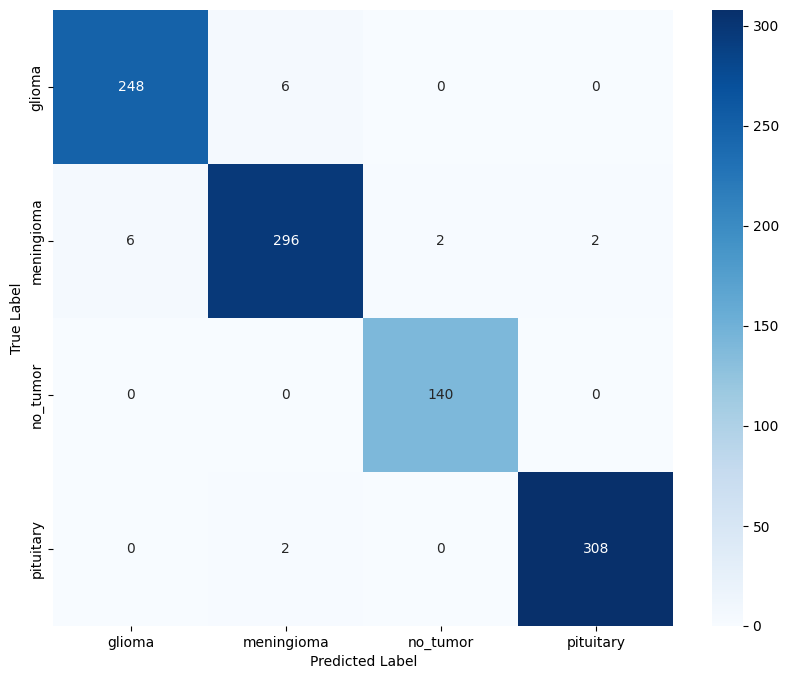


--- Training History Plots ---


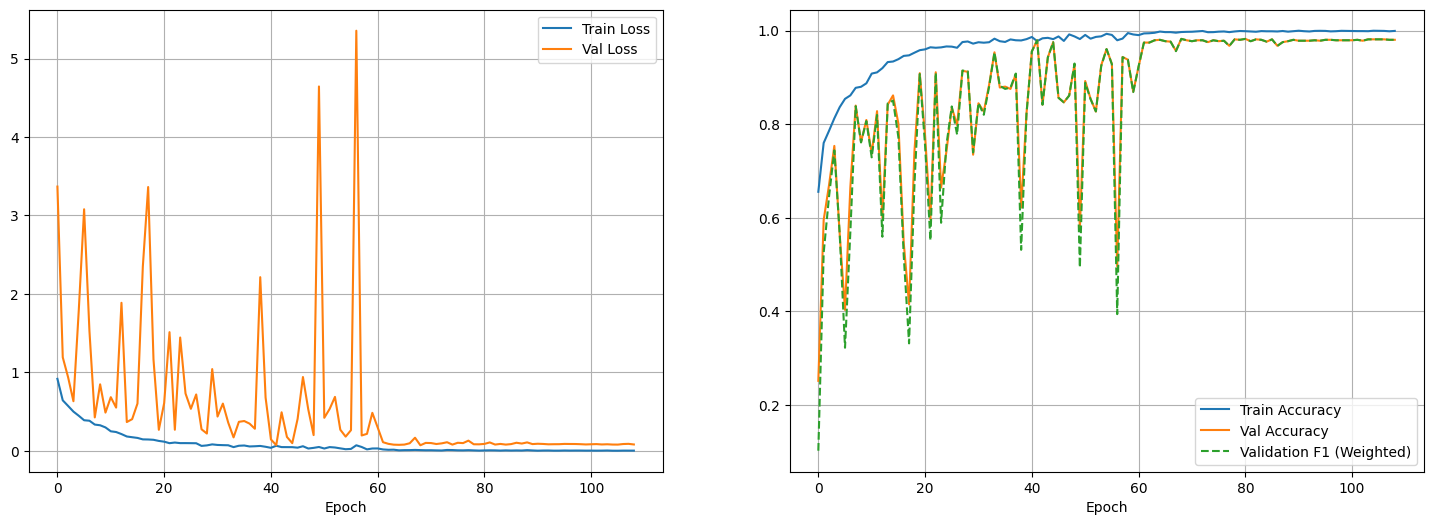


--- ROC Curve Analysis ---


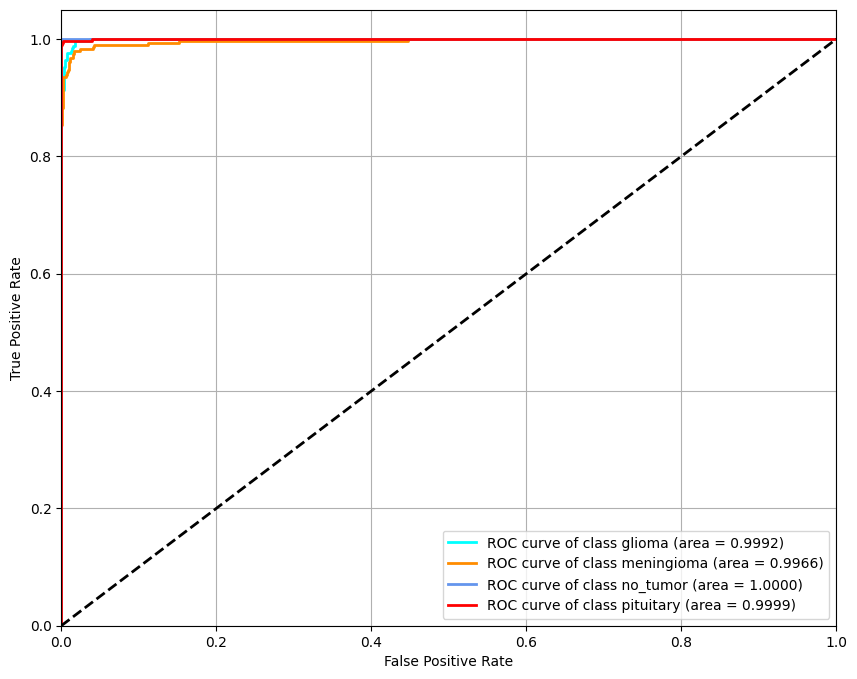


--- Script Finished ---


In [ ]:
# ======================
# BLOCK 5: EVALUATION
# ======================
print("\n\n--- Final Evaluation on BRISC2025 dataset ---")

try:
    print(f"Loading best model from: {CLASSIFIER_MODEL_PATH_BASELINE}")
    best_model = models.load_model(CLASSIFIER_MODEL_PATH_BASELINE)

    # --- 1. Evaluating Loss and Accuracy ---
    print("\n--- Calculating Loss and Accuracy on Test Set ---")
    loss, accuracy = best_model.evaluate(X_test, y_test, verbose=0)
    print(f"Test Loss:      {loss:.4f}")
    print(f"Test Accuracy:  {accuracy:.4f}")

    # --- 2. Getting Predictions ---
    y_pred_proba = best_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred_proba, axis=1)

    # --- 3. Detailed Metrics ---
    print("\n--- Detailed Performance Metrics ---")
    macro_f1 = f1_score(y_test, y_pred_classes, average='macro', zero_division=0)
    weighted_f1 = f1_score(y_test, y_pred_classes, average='weighted', zero_division=0)
    print(f"Macro F1 Score:   {macro_f1:.4f}")
    print(f"Weighted F1 Score:{weighted_f1:.4f}")

    kappa = cohen_kappa_score(y_test, y_pred_classes)
    mcc = matthews_corrcoef(y_test, y_pred_classes)
    print(f"Cohen's Kappa:    {kappa:.4f}")
    print(f"MCC:              {mcc:.4f}")

    auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='macro')
    weighted_auc_roc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted')
    print(f"AUC-ROC (Macro):  {auc_roc:.4f}")
    print(f"AUC-ROC (Weighted):{weighted_auc_roc:.4f}")

    # --- 4. Classification Report ---
    print("\n--- Classification Report ---")
    print(classification_report(y_test, y_pred_classes, target_names=CLASS_NAMES, digits=4, zero_division=0))

    # --- 5. Confusion Matrix ---
    cm = confusion_matrix(y_test, y_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    # plt.title('Spatial-Only Baseline on BRISC2025')
    plt.show()

    # --- 6. Plotting Training History ---
    if 'history_baseline' in locals() or 'history_baseline' in globals():
        print("\n--- Training History Plots ---")
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 6))
        ax1.plot(history_baseline.history['loss'], label='Train Loss')
        ax1.plot(history_baseline.history['val_loss'], label='Val Loss')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.legend()
        ax1.grid(True)
        ax2.plot(history_baseline.history['accuracy'], label='Train Accuracy')
        ax2.plot(history_baseline.history['val_accuracy'], label='Val Accuracy')
        if 'val_f1_weighted' in history_baseline.history:
            ax2.plot(history_baseline.history['val_f1_weighted'], label='Validation F1 (Weighted)', linestyle='--')
        ax2.set_title('Model Performance')
        ax2.set_xlabel('Epoch')
        ax2.legend()
        ax2.grid(True)
        plt.show()

    # --- 7. ROC Curve Plot ---
    print("\n--- ROC Curve Analysis ---")
    y_test_binarized = label_binarize(y_test, classes=range(len(CLASS_NAMES)))
    n_classes = y_test_binarized.shape[1]
    fpr, tpr, roc_auc_dict = dict(), dict(), dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_proba[:, i])
        roc_auc_dict[i] = auc(fpr[i], tpr[i])
    plt.figure(figsize=(10, 8))
    colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'purple', 'brown'])
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'ROC curve of class {CLASS_NAMES[i]} (area = {roc_auc_dict[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    # plt.title('Multi-Class Receiver Operating Characteristic (ROC)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"An error occurred during evaluation: {e}")

print("\n--- Script Finished ---")